In [2]:
from traffic import rho_red_light, computeF

In [6]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)
    Computes "red light" initial condition with shock
    
    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density



In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [6]:
# Basic initial condition parameters
# defining grid size, time steps, CFL condition, etc...

nx = 100
nt = 30
dx = 4.0/nx

rho_in = 5.
rho_max = 10.

V_max = 1.

# x_i now is the center of the i-th cell
x = numpy.linspace(0+0.5*dx, 4-0.5*dx, nx)

rho = rho_red_light(nx, rho_max, rho_in)

G:\Users\Michael Orrill\Documents\local_repo\mae6286\module_3\traffic.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rho[:(nx-1)*3./4.] = rho_in


In [8]:
# functions
# animation function
def animate(data):
    x = numpy.linspace(0+0.5*dx, 4-0.5*dx, nx)
    y = data
    line.set_data(x,y)
    return line,

# Godunov's method function
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    # initialize our results array with dimension nt by nx
    rho_n = numpy.zeros((nt, len(rho)))
    # copy initial u array into each row of new array
    rho_n[:,:] = rho.copy()
    
    # setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    
    for t in range(1,nt):
        rho_plus[:-1] = rho[1:] # Cant do i + 1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i + 1/2
        flux = 0.5*(computeF(V_max, rho_max, rho_minus) + 
                    computeF(V_max, rho_max, rho_plus) + 
                    dx/dt*(rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2] - flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

In [21]:
sigma = 0.5
dt = sigma*dx/V_max

rho = rho_red_light(nx, rho_max, rho_in) # make sure u is set to our expected IC
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

G:\Users\Michael Orrill\Documents\local_repo\mae6286\module_3\traffic.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rho[:(nx-1)*3./4.] = rho_in


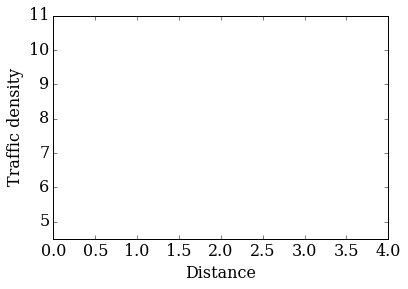

In [50]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'))
line, = ax.plot([],[],color='#003366', lw=2);

In [23]:
anim = animation.FuncAnimation(fig,animate,frames=rho_n, interval=50)
HTML(anim.to_html5_video())

### Digging deeper
- Use Godunov's method on the green light problem with initial condition for waves traveling in both directions.
- Also use different flux schemes

In [24]:
# green light initial condition function:
def rho_green_light(nx, rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_light : float
        Density of cars at stoplight

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """    
    rho = numpy.arange(nx)*2./nx*rho_light # Before stoplight
    rho[int((nx-1)/2):] = 0
    return rho

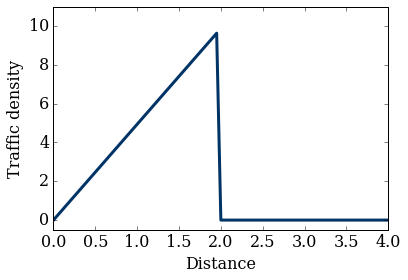

In [26]:
# initial conditions and plot
# Initial condition paramters
# defining grid size and time steps

nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4,nx)

rho_max = 10.
rho_light = 10.

rho = rho_green_light(nx, rho_light)

pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5, 11.);

In [27]:
# calculate solution:
sigma = 1.
dt = sigma*dx

rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

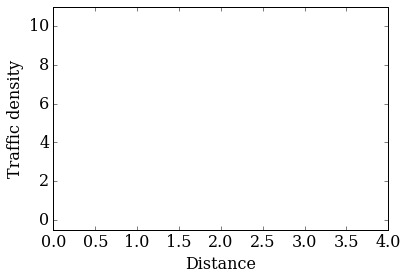

In [30]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-0.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [31]:
# solution for Godunov's method using the current flux scheme
anim = animation.FuncAnimation(fig,animate,frames=rho_n, interval=50)
HTML(anim.to_html5_video())

Could not find, interpret, and understand other flux schemes. Will come back to this if I have time.
- Are schems for solving the problem or for the flux term?

In [44]:
# minmod function
def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e : array of float 
        input data
    dx : float 
        spacestep
    
    Returns
    -------
    sigma : array of float 
            minmod slope
    """
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # this is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i]*de_plus[i] <0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
    return sigma

# MUSCL function
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using the Lax-Friedrichs flux,
    RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    # initialize results array with dimensions nt by nx
    rho_n = numpy.zeros((nt, len(rho)))
    # copy initial rho array into each row of our new array
    rho_n[:,:] = rho.copy()
    
    # set up temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)
    
    for t in range(1, nt):
        sigma = minmod(rho,dx) # calculate minmod slope
        # reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2
        rho_right = rho - sigma*dx/2
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        # flux i = i + 1/2
        flux[:-1] = 0.5*(flux_right[1:] + flux_left[:-1] - dx/dt*(rho_right[1:] - rho_left[:-1]))
        
        # rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx*(flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        sigma = minmod(rho_star, dx) # recalculate minmod slope
        
        # reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2
        rho_right = rho_star - sigma*dx/2
        
        flux_left = computeF(V_max, rho_max, rho_left)
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5*(flux_right[1:] + flux_left[:-1] - dx/dt*(rho_right[1:] - rho_left[:-1]))
        
        rho_n[t,1:-1] = 0.5*(rho[1:-1] + rho_star[1:-1] + dt/dx*(flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

In [45]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx, rho_max, rho_in)
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)

G:\Users\Michael Orrill\Documents\local_repo\mae6286\module_3\traffic.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rho[:(nx-1)*3./4.] = rho_in


In [51]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())